In [1]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

In [2]:
filename1 = '/home/mabbasloo/Documents/Dyna/data/mlist'
filename2 = '/home/mabbasloo/Documents/Dyna/data/flist'

hm1 = 10
hm2 = 10

with open(filename1) as f:
    data1 = f.readlines() 
data1 = [x.strip() for x in data1]  
data1 = data1[hm1:hm2]
for i in range(len(data1)):
    print (data1[i])

hm1 = 10
hm2 = 11

with open(filename2) as f:
    data2 = f.readlines() 
data2 = [x.strip() for x in data2]   
data2 = data2[hm1:hm2]    
for i in range(len(data2)):
    print (data2[i])

50004_punching


In [3]:
d = 40

st = 10
stride = 6

window = 1
hmw = 160

name = '/home/mabbasloo/Documents/Dyna/data'

In [4]:
DATA = np.zeros((len(data1)*hmw, st, 3, d))
c = -1
for I in range(len(data1)):
    db = h5py.File(name + '/m_LBO/' + data1[I] + '_0.mat', 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    for II in range(hmw):
        c = c + 1
        for i in range(st):
            db1 = h5py.File(name + '/m/' + data1[I] + '_' + np.str(window*II + stride*i) + '.mat', 'r')
            ds1 = db1['shape_xyz']
            ds1 = np.asarray(ds1).astype(np.float32)
            DATA[c, i] = np.dot(ds1, ds)

# normalization            
LX1 = []
LY1 = []
LZ1 = []
for I in range(len(data1)):    
    lx = np.linalg.norm(DATA[hmw*I, :, 0, :])/st
    ly = np.linalg.norm(DATA[hmw*I, :, 1, :])/st
    lz = np.linalg.norm(DATA[hmw*I, :, 2, :])/st
    LX1.append(lx)
    LY1.append(ly)
    LZ1.append(lz) 
    for i in range(hmw*I, hmw*(I+1)):
        for ii in range(st):
            DATA[i, ii, 0] = DATA[i, ii, 0]/lx
            DATA[i, ii, 1] = DATA[i, ii, 1]/ly
            DATA[i, ii, 2] = DATA[i, ii, 2]/lz  
print (LX1, LY1, LZ1)
seq_in_ = DATA.reshape((len(data1)*hmw, st, 3*d))

# shuffle data
for I in range(len(data1)):
    shuf = np.random.randint(hmw, size=hmw)
    dummy = seq_in_[hmw*I:hmw*(I+1)]
    dummy = dummy[shuf]
    seq_in_[hmw*I:hmw*(I+1)] = dummy
print (seq_in_.shape)

[] [] []
(0, 10, 120)


In [5]:
DATA = np.zeros((len(data2)*hmw, st, 3, d))
c = -1
for I in range(len(data2)):
    db = h5py.File(name + '/f_LBO/' + data2[I] + '_0.mat', 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    for II in range(hmw):
        c = c + 1
        for i in range(st):
            db1 = h5py.File(name + '/f/' + data2[I] + '_' + np.str(window*II+stride*i) + '.mat', 'r')
            ds1 = db1['shape_xyz']
            ds1 = np.asarray(ds1).astype(np.float32)
            DATA[c, i] = np.dot(ds1, ds)
            
# normalization                        
LX2 = []
LY2 = []
LZ2 = []
for I in range(len(data2)):    
    lx = np.linalg.norm(DATA[hmw*I, :, 0, :])/st
    ly = np.linalg.norm(DATA[hmw*I, :, 1, :])/st
    lz = np.linalg.norm(DATA[hmw*I, :, 2, :])/st
    LX2.append(lx)
    LY2.append(ly)
    LZ2.append(lz) 
    for i in range(hmw*I, hmw*(I+1)):
        for ii in range(st):
            DATA[i, ii, 0] = DATA[i, ii, 0]/lx
            DATA[i, ii, 1] = DATA[i, ii, 1]/ly
            DATA[i, ii, 2] = DATA[i, ii, 2]/lz 
print (LX2, LY2, LZ2)            
seq_test_ = DATA.reshape((len(data2)*hmw, st, 3*d))

# shuffle data
for I in range(len(data2)):
    shuf = np.random.randint(hmw, size=hmw)
    dummy = seq_test_[hmw*I:hmw*(I+1)]
    dummy = dummy[shuf]
    seq_test_[hmw*I:hmw*(I+1)] = dummy
print (seq_test_.shape)
DATA = []

[683.8740069646699] [1487.6745500439056] [585.6439238521556]
(160, 10, 120)


In [6]:
hmh = np.int(hmw/5.0)
seq_in = np.append(seq_in_, seq_test_[hmh:], axis=0)
seq_test = seq_test_[0:hmh]
print (seq_in.shape)
print (seq_test.shape)

(128, 10, 120)
(32, 10, 120)


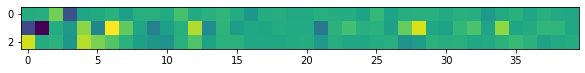

In [7]:
plt.figure(figsize=(10, 10)); plt.imshow(seq_in[0, 0].reshape((3, d)))

In [8]:
# lstm autoencoder reconstruct and predict sequence
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model



n_in = seq_in.shape[1]

# prepare output sequence
l = np.int(st/2.0)
seq_out = seq_in[:, l:, :]
n_out = n_in - l

# define encoder
visible = Input(shape=(n_in, 3*d))
encoder = LSTM(1000, activation='relu')(visible)

# define reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(1500, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(3*d))(decoder1)

# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(2000, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(3*d))(decoder2)

# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

Using TensorFlow backend.
W0909 17:53:04.328601 140671742158656 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 17:53:04.338222 140671742158656 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 17:53:04.340883 140671742158656 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 17:53:11.799773 140671742158656 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/optimizers.py:790:

In [9]:
# fit model
model.fit(seq_in, [seq_in, seq_out], epochs=200, verbose=0)

W0909 17:53:12.130987 140671742158656 deprecation.py:323] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0909 17:53:13.151580 140671742158656 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0909 17:53:13.260338 140671742158656 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [10]:
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print (len(yhat), yhat[0].shape)

2 (128, 10, 120)


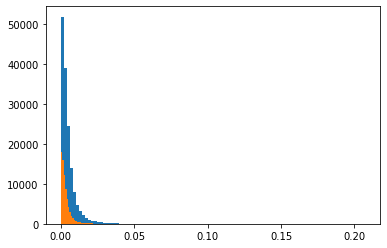

In [11]:
_,_,_ = plt.hist(np.abs(yhat[0] - seq_in).reshape(seq_in.shape[0]*seq_in.shape[1]*seq_in.shape[2]), bins=100)
_,_,_ = plt.hist(np.abs(yhat[1] - seq_in[:, l:, :]).reshape(seq_in.shape[0]*(seq_in.shape[1]-l)*seq_in.shape[2]), bins=100)

In [12]:
# demonstrate prediction
yhat = model.predict(seq_test, verbose=0)
print (len(yhat), yhat[0].shape)

2 (32, 10, 120)


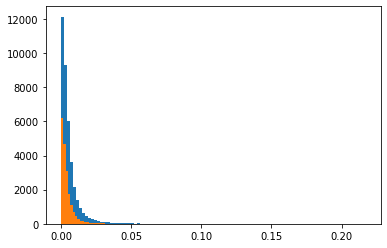

In [13]:
_,_,_ = plt.hist(np.abs(yhat[0] - seq_test).reshape(seq_test.shape[0]*seq_test.shape[1]*seq_test.shape[2]), bins=100)
_,_,_ = plt.hist(np.abs(yhat[1] - seq_test[:, l:, :]).reshape(seq_test.shape[0]*(seq_test.shape[1]-l)*seq_test.shape[2]), bins=100)

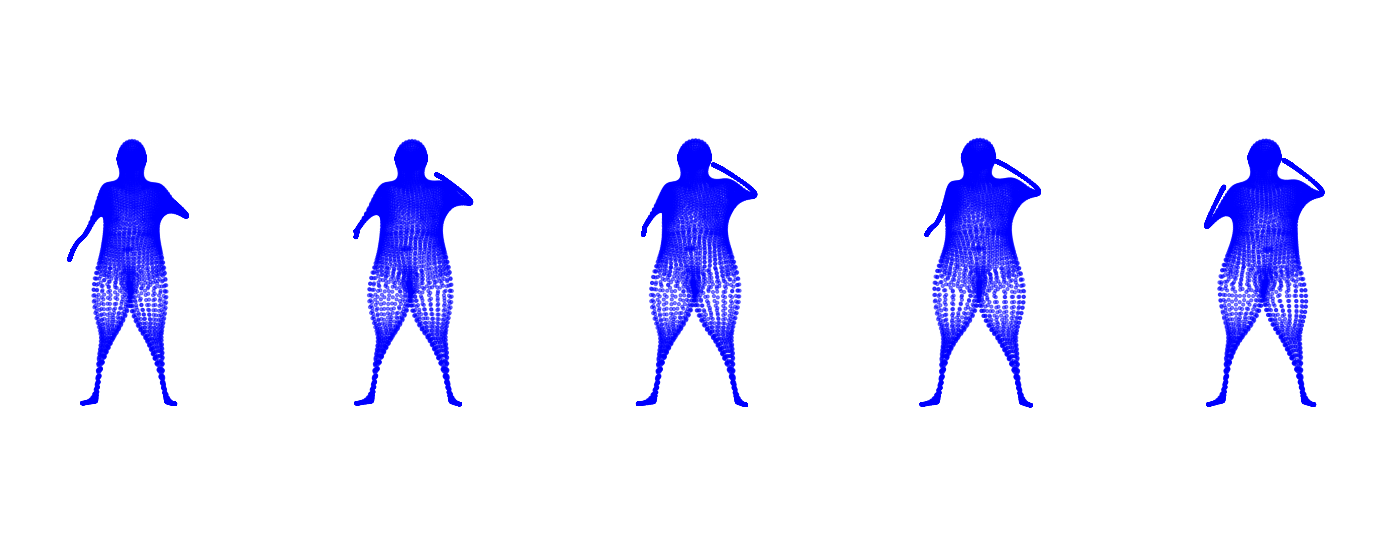

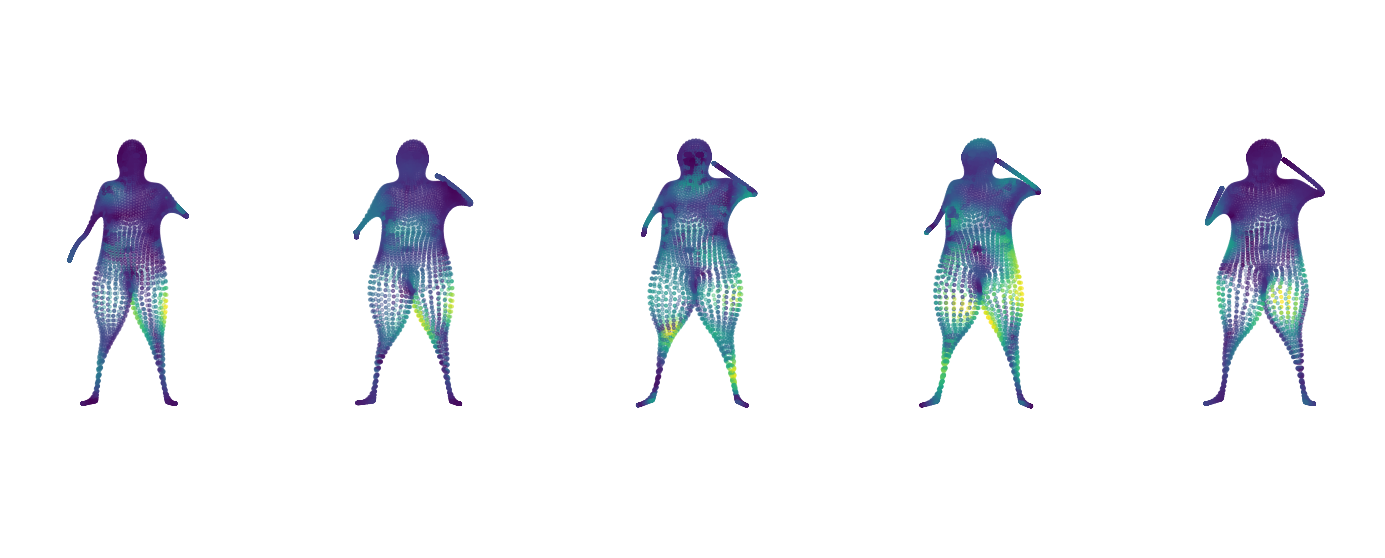

In [14]:
which = 0
whichh = 0

x_reconstructed = yhat[1].reshape((len(seq_test), (st-l), 3, d)) 
db = h5py.File(name + '/f_LBO/' + data2[which] + '_0.mat', 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
lxyz = np.array([[LX2[which], 0, 0],
                 [0, LY2[which], 0],
                 [0, 0, LZ2[which]]])
fig = plt.figure(figsize=(l*10, 10))
figg = plt.figure(figsize=(l*10, 10))
for i in range(l, st):
    xyz = np.dot(np.dot(lxyz, seq_test[whichh, i].reshape((3, d))), np.linalg.pinv(ds))
    xyz_reconstructed = np.dot(np.dot(lxyz, x_reconstructed[whichh, i-l]), np.linalg.pinv(ds))
    cl = np.linalg.norm(np.abs(xyz - xyz_reconstructed), axis=0)
    m = ['o', 'o']   
    ax = fig.add_subplot(1, 10, i-l+1, projection='3d')
    axx = figg.add_subplot(1, 10, i-l+1, projection='3d')
    ax.scatter(xyz[0], xyz[1], xyz[2], c='b', marker=m[0], alpha=0.5, s=10)
    axx.scatter(xyz_reconstructed[0], xyz_reconstructed[1], xyz_reconstructed[2], c=cl, marker=m[1], s=10)
    ax.view_init(90, -90)
    ax.set_axis_off()
    axx.view_init(90, -90) 
    axx.set_axis_off()